# The Price is Right
A more complex solution for estimating prices of goods.

1. This notebook: create a RAG database with our 400,000 training data
2. Pr11.ThePriceIsRight-Rag2.1 notebook: visualize in 2D
3. Pr11.ThePriceIsRight-Rag2.2 notebook: visualize in 3D
4. Pr11.ThePriceIsRight-Rag2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Pr11.ThePriceIsRight-Rag2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

I will now train a Random Forest model.

I'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [8]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [9]:
rf_model = joblib.load('random_forest_model.pkl')

In [10]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [11]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [12]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [13]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $151.47 Truth: $59.99 Error: $91.48 SLE: 0.84 Item: 3-in-1 Pocket Hole Jig Kit, Woodworking ...
2: Guess: $172.49 Truth: $79.99 Error: $92.50 SLE: 0.58 Item: Bioluz LED 8 Pack 5"/6-inch 75 Watt (Use...
3: Guess: $182.40 Truth: $29.99 Error: $152.41 SLE: 3.16 Item: FiberShack - Fiber Optic ST Coupler & 2....
4: Guess: $117.42 Truth: $82.99 Error: $34.43 SLE: 0.12 Item: Mig Gun Welding Torch Holder Mig Gun Hol...
5: Guess: $191.05 Truth: $182.00 Error: $9.05 SLE: 0.00 Item: EGLO Mundazo 4-Light Semi Flush Modern C...
6: Guess: $278.13 Truth: $118.45 Error: $159.68 SLE: 0.72 Item: Lenovo 32GB TruDDR4 Memory Module
7: Guess: $399.67 Truth: $249.99 Error: $149.68 SLE: 0.22 Item: Jackson JS Series Monarkh SC JS22, Amara...
8: Guess: $300.65 Truth: $667.00 Error: $366.35 SLE: 0.63 Item: MagnaFlow Direct-Fit Catalytic Converter...
9: Guess: $295.54 Truth: $368.86 Error: $73.32 SLE: 0.05 Item: Gigabyte G1.Sniper Z87 LGA 1150 Intel Cr...
10: Guess: $142.84 Truth: $124.96 Error: $17.88 

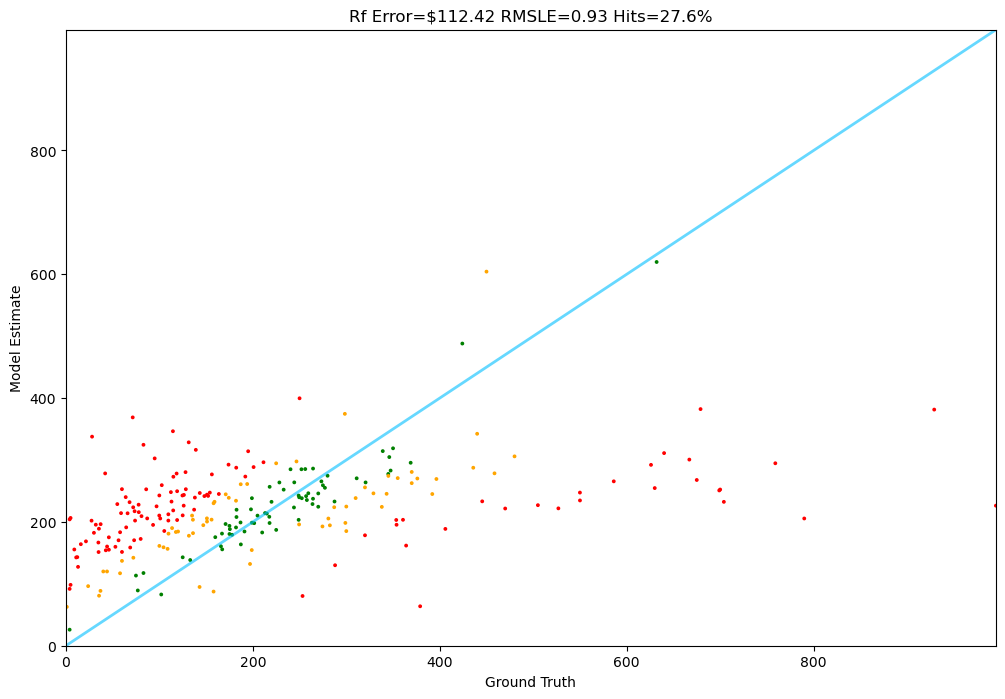

In [14]:
Tester.test(rf, test)

In [25]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [26]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
260.3920000000001


In [27]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:26<00:00,  3.95s/it]


In [28]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [29]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.97
Frontier: 0.18
RandomForest: 0.23
Min: -0.23
Max: -0.18
Intercept=9.34


In [30]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [31]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [32]:
ensemble.price(product)

200.3057417476009

In [33]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $44.31 Truth: $59.99 Error: $15.68 SLE: 0.09 Item: 3-in-1 Pocket Hole Jig Kit, Woodworking ...
2: Guess: $121.90 Truth: $79.99 Error: $41.91 SLE: 0.17 Item: Bioluz LED 8 Pack 5"/6-inch 75 Watt (Use...
3: Guess: $96.95 Truth: $29.99 Error: $66.96 SLE: 1.32 Item: FiberShack - Fiber Optic ST Coupler & 2....
4: Guess: $92.94 Truth: $82.99 Error: $9.95 SLE: 0.01 Item: Mig Gun Welding Torch Holder Mig Gun Hol...
5: Guess: $190.70 Truth: $182.00 Error: $8.70 SLE: 0.00 Item: EGLO Mundazo 4-Light Semi Flush Modern C...
6: Guess: $302.83 Truth: $118.45 Error: $184.38 SLE: 0.87 Item: Lenovo 32GB TruDDR4 Memory Module
7: Guess: $339.04 Truth: $249.99 Error: $89.05 SLE: 0.09 Item: Jackson JS Series Monarkh SC JS22, Amara...
8: Guess: $585.34 Truth: $667.00 Error: $81.66 SLE: 0.02 Item: MagnaFlow Direct-Fit Catalytic Converter...
9: Guess: $303.79 Truth: $368.86 Error: $65.07 SLE: 0.04 Item: Gigabyte G1.Sniper Z87 LGA 1150 Intel Cr...
10: Guess: $121.11 Truth: $124.96 Error: $3.85 SLE: 0.0

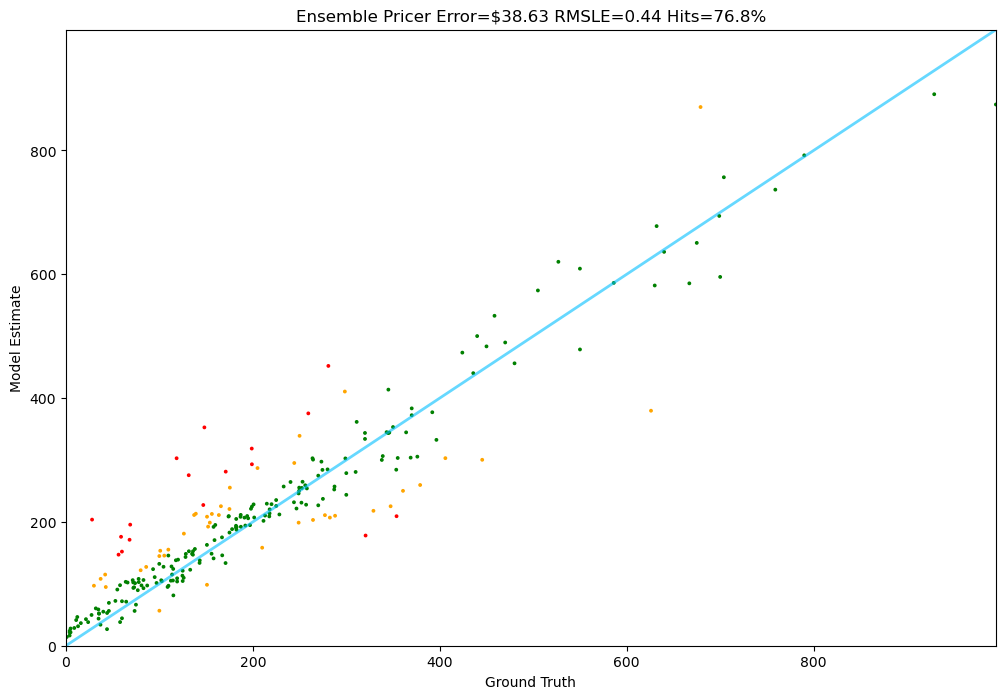

In [34]:
Tester.test(ensemble_pricer, test)